# Algorithms for decision making

## Algorithm 2.1. 
Types and functions relevant to working with factors over a set of discrete variables. A variable is given a name (represented as a symbol) and may take on an integer from 1 to m. An assignment is a mapping from variable names to values represented as integers. A factor is defined by a factor table that assigns values to different assignments involving a set of variables. A factor table is a mapping from assignments to real values. This mapping is represented by a dictionary. Any assignments not contained in the dictionary are set to 0. Also included in this algorithm block are some utility functions for returning the variable names associated with a factor, selecting a subset of an assignment, enumerating possible assignments,
and normalizing factors. As discussed in appendix G.3.3, product produces the Cartesian product of a set of collections. It is imported from Base.Iterators.

In [1]:
struct Variable
    name::Symbol
    m::Int
end

const Assignment = Dict{Symbol,Int}
const FactorTable = Dict{Assignment,Float64}

struct Factor
    vars::Vector{Variable}
    table::FactorTable
end

variablenames(Φ::Factor) = [var.name for var in Φ.vars]

select(a::Assignment, varnames::Vector{Symbol}) = Assignment(n=>a[n] for n in varnames)

function assignments(vars::AbstractVector{Variable})
    names = [var.name for var in vars]
    return vec([Assignment(n=>v for (n,v) in zip(names,values)) for values in product((1:v.m for v in vars)...)])
end

function normalize!(Φ::Factor)
    z = sum(p for (a,p) in Φ.table)
    for (a,p) in Φ.table
        Φ.table[a] = p/z
    end
    return Φ
end

normalize! (generic function with 1 method)

## Example 2.3. 
Constructing a discrete factor. The construction of the factor table using named tuples takes advantage of the utility functions defined in appendix G.5.

We can instantiate the table from table 2.1 using the Factor type using the following code:

In [2]:
X = Variable(:x, 2)
Y = Variable(:y, 2)
Z = Variable(:z, 2)
Φ = Factor([X, Y, Z], FactorTable(
    Dict(:x=>1, :y=>1, :z=>1)=>0.08, Dict(:x=>1, :y=>1, :z=>2)=>0.31,
    Dict(:x=>1, :y=>2, :z=>2)=>0.09, Dict(:x=>1, :y=>2, :z=>2)=>0.37,
    Dict(:x=>2, :y=>1, :z=>1)=>0.01, Dict(:x=>2, :y=>1, :z=>2)=>0.05,
    Dict(:x=>2, :y=>2, :z=>1)=>0.02, Dict(:x=>2, :y=>2, :z=>2)=>0.07
))

Factor(Variable[Variable(:x, 2), Variable(:y, 2), Variable(:z, 2)], Dict(Dict(:y => 1, :z => 1, :x => 1) => 0.08, Dict(:y => 1, :z => 1, :x => 2) => 0.01, Dict(:y => 1, :z => 2, :x => 1) => 0.31, Dict(:y => 2, :z => 2, :x => 1) => 0.37, Dict(:y => 2, :z => 1, :x => 2) => 0.02, Dict(:y => 1, :z => 2, :x => 2) => 0.05, Dict(:y => 2, :z => 2, :x => 2) => 0.07))

# Algorithm 2.2.
A discrete Bayesian network representation in terms of a set of variables, factors, and a graph. The graph data structure is provided by LightGraphs.jl.

In [3]:
using LightGraphs
struct BayesianNetwork
    vars:: Vector{Variable}
    factors::Vector{Factor}
    graph::SimpleDiGraph{Int64}
end

Below the caption is a Bayesian network for a satellite-monitoring problem involving five binary variables. Fortunately, battery failure and solar panel failures are both rare, although solar panel failures are somewhat more likely than battery failures. Failures in either can lead to an electrical system failure. There may be causes of electrical system failure other than battery or solar panel failure, such as a problem with the power management unit. An electrical system failure can result in trajectory deviation, which can be observed from the earth by telescope, as well as a communicaition loss that interrupts the transmission of telemetry and mission data down to various ground stations. Other anomalies not involving the electrical system can result in trajectory deviation and communication loss.
Associated with each of the five variables are five conditional probability distributions. Because B and S do not have any parents, we only need to specify P(B) and P(S). The code below creates a Bayesian network structure with example values for the elements of the associated factor tables. The tuples in the factor tables index into the domains of the variables, which is {0,1} for all of the variables. For example, (e=2,b=1,s=1) corresponds to (e^1, b^0, s^0).

# Example 2.5.
A Bayesian network representing a satellite-monitoring problem. Below is the structure of the network represented as a directed acyclic graph. Associated with each node is a conditional probability distribution.
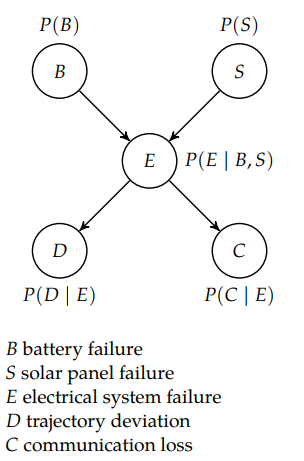

In [4]:
B = Variable(:b, 2)
S = Variable(:s, 2)
E = Variable(:e, 2)
D = Variable(:d, 2)
C = Variable(:c, 2)

vars = [B, S, E, D, C]

factors = [
    Factor([B], FactorTable(
            Dict(:b=>1,)=>0.99,
            Dict(:b=>2,)=>0.01
        )
    ),
    Factor([S], FactorTable(
            Dict(:s=>1,)=>0.98,
            Dict(:s=>2,)=>0.02
        )
    ),
    Factor([E,B,S], FactorTable(
            Dict(:e=>1,:b=>1,:s=>1)=>0.90, Dict(:e=>1,:b=>1,:s=>2)=>0.04,
            Dict(:e=>1,:b=>2,:s=>1)=>0.05, Dict(:e=>1,:b=>2,:s=>2)=>0.01,
            Dict(:e=>2,:b=>1,:s=>1)=>0.95, Dict(:e=>2,:b=>2,:s=>2)=>0.99
        )
    ),
    Factor([D,E], FactorTable(
            Dict(:d=>1,:e=>1)=>0.96,
            Dict(:d=>1,:e=>2)=>0.03,
            Dict(:d=>2,:e=>1)=>0.04,
            Dict(:d=>2,:e=>2)=>0.97
        )
    ),
    Factor([C,E], FactorTable(
            Dict(:c=>1,:e=>1)=>0.98,
            Dict(:c=>1,:e=>2)=>0.01,
            Dict(:c=>2,:e=>1)=>0.02,
            Dict(:c=>2,:e=>2)=>0.99
        )
    )
]
graph = SimpleDiGraph(5)
add_edge!(graph,1,3)
add_edge!(graph,2,3)
add_edge!(graph,3,4)
add_edge!(graph,3,5)
bn = BayesianNetwork(vars, factors, graph)

BayesianNetwork(Variable[Variable(:b, 2), Variable(:s, 2), Variable(:e, 2), Variable(:d, 2), Variable(:c, 2)], Factor[Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.01, Dict(:b => 1) => 0.99)), Factor(Variable[Variable(:s, 2)], Dict(Dict(:s => 1) => 0.98, Dict(:s => 2) => 0.02)), Factor(Variable[Variable(:e, 2), Variable(:b, 2), Variable(:s, 2)], Dict(Dict(:b => 1, :s => 1, :e => 2) => 0.95, Dict(:b => 2, :s => 2, :e => 2) => 0.99, Dict(:b => 1, :s => 2, :e => 1) => 0.04, Dict(:b => 1, :s => 1, :e => 1) => 0.9, Dict(:b => 2, :s => 2, :e => 1) => 0.01, Dict(:b => 2, :s => 1, :e => 1) => 0.05)), Factor(Variable[Variable(:d, 2), Variable(:e, 2)], Dict(Dict(:d => 2, :e => 1) => 0.04, Dict(:d => 2, :e => 2) => 0.97, Dict(:d => 1, :e => 1) => 0.96, Dict(:d => 1, :e => 2) => 0.03)), Factor(Variable[Variable(:c, 2), Variable(:e, 2)], Dict(Dict(:e => 2, :c => 1) => 0.01, Dict(:e => 2, :c => 2) => 0.99, Dict(:e => 1, :c => 2) => 0.02, Dict(:e => 1, :c => 1) => 0.98))], {5, 4} directed

# Algorithm 2.3. 
A function for evaluating the probability of an assignment given a Bayesian network nb. For example, if bn is as defined in example 2.5, then a = (b=1,s=1,e=1,d=2,c=1) probability(bn, Assignment(a)) returns 0.03422865599.

In [5]:
function probability(nb::BayesianNetwork, assignment)
    subassignment(Φ) = select(assighment, variablenames(Φ))
    probability(Φ) = get(Φ.table, subassignment(Φ), 0.0)
    return prod(probability(Φ) for Φ in nb.factors)
end

probability (generic function with 1 method)